1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
from scipy import stats as stats
from numpy import linalg as la

In [48]:
#Create the 3 columns of data and full dataset
N = 1000
feat1 = np.random.normal(loc=0, scale=1, size=N)
feat2 = feat1 + np.random.normal(loc=0, scale=3, size=N)
feat3 = 2*feat1 + feat2

dataset = np.array([feat1, feat2, feat3])

# covariance matrix
cov = np.cov(dataset)

#Eigenvectors and eigenvalues of the covariance matrix
w, v = la.eig(cov) 
laEigVals = w
laEigVecs = np.transpose(v)
print(f'The eigenvalues of the covariance matrix usind LA are: {laEigVals}')
print(f'The eigenvectors of the covariace matrix using LA are: {laEigVecs}\n')

#Eigenvectors and eigenvalues using SVD
U, spectrum, Vt = la.svd(cov)
print(f'The eigenvalues of the covariance matrix using SVD are: {spectrum}')
print(f'The eigenvectors of the covariace matrix using SVD are: {Vt}\n')

print('The eigenvectors and eigenvalues using both methods are the same, just sorted differently \n')

# Percent of datasets variability
Lambda = np.diag(w)
covTrace = cov.trace()
lambdaTrace = Lambda.trace()

print(f"{Lambda[0,0]/Lambda.trace()*100}% of the dataset's variability is explained by the principal components\n")

# We can reduce the dimensionality of the dataset by removing the last variable x3, since 
# it is just a linear combination of the first two variables and adds no useful new info
newData = np.array([dataset[0], dataset[1]])

# Redefine the data in new basis
l0, V0 = np.linalg.eig(np.dot(dataset, dataset.T)/(N-1))
Xp = np.dot(V0.T, dataset)

print(f'Data redifined in new basis: {Xp}')

The eigenvalues of the covariance matrix usind LA are: [ 2.69147587e+01 -1.54766810e-16  2.02538991e+00]
The eigenvectors of the covariace matrix using LA are: [[-0.11600384 -0.57668271 -0.8086904 ]
 [-0.81649658 -0.40824829  0.40824829]
 [ 0.5655762  -0.70765131  0.4235011 ]]

The eigenvalues of the covariance matrix using SVD are: [2.69147587e+01 2.02538991e+00 1.55129812e-16]
The eigenvectors of the covariace matrix using SVD are: [[-0.11600384 -0.57668271 -0.8086904 ]
 [ 0.5655762  -0.70765131  0.4235011 ]
 [ 0.81649658  0.40824829 -0.40824829]]

The eigenvectors and eigenvalues using both methods are the same, just sorted differently 

93.00145297598418% of the dataset's variability is explained by the principal components

Data redifined in new basis: [[ 2.67827371e+00  1.50852675e+00  3.57435371e+00 ...  3.62839374e-01
  -4.64842355e+00 -2.45966916e-01]
 [ 1.07611935e-15 -1.61664851e-16  2.71925314e-16 ...  2.85922159e-16
   3.95401842e-16  7.97735064e-16]
 [-3.10110141e+00  2.3

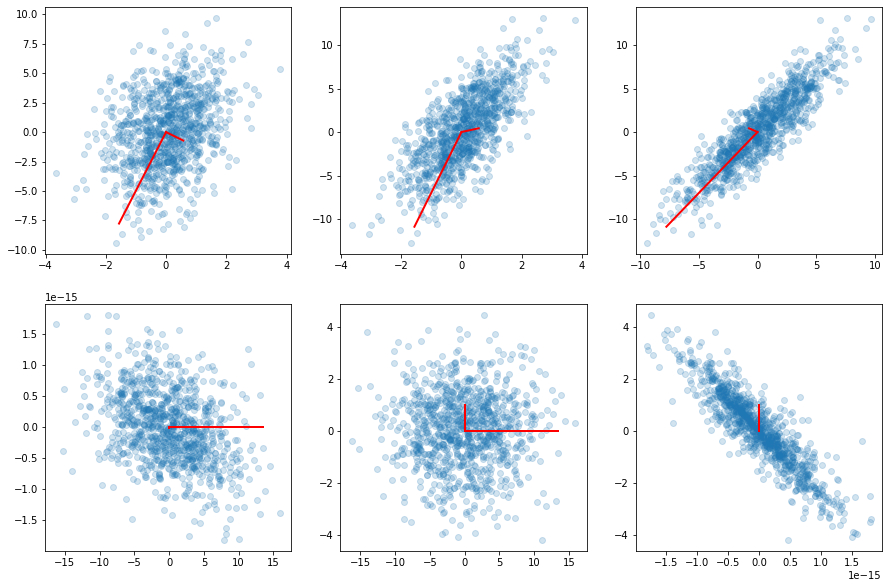

In [61]:
# Plot data points
gridsize = (2, 3)
fig = plt.figure(figsize=(15, 10))
ax00 = plt.subplot2grid(gridsize, (0, 0))
ax01 = plt.subplot2grid(gridsize, (0, 1))
ax02 = plt.subplot2grid(gridsize, (0, 2))
ax10 = plt.subplot2grid(gridsize, (1, 0))
ax11 = plt.subplot2grid(gridsize, (1, 1))
ax12 = plt.subplot2grid(gridsize, (1, 2))
scaleFactor=0.5

#original data
l, V = la.eig(np.cov(dataset))

ax00.scatter(dataset[0,:], dataset[1,:], alpha=0.2)
for li, vi in zip(l, V.T):
    ax00.plot([0, scaleFactor*li*vi[0]], [0, scaleFactor*li*vi[1]], 'r-', lw=2)

ax01.scatter(dataset[0,:], dataset[2,:], alpha=0.2)
for li, vi in zip(l, V.T):
    ax01.plot([0, scaleFactor*li*vi[0]], [0, scaleFactor*li*vi[2]], 'r-', lw=2)

ax02.scatter(dataset[1,:], dataset[2,:], alpha=0.2)
for li, vi in zip(l, V.T):
    ax02.plot([0, scaleFactor*li*vi[1]], [0, scaleFactor*li*vi[2]], 'r-', lw=2)

#new data
l0, V0 = np.linalg.eig(np.dot(dataset, dataset.T)/(N-1))

ax10.scatter(Xp[0,:], Xp[1,:], alpha=0.2)
for li, vi in zip(l0, np.diag([1]*3)):
    ax10.plot([0, scaleFactor*li*vi[0]], [0, scaleFactor*li*vi[1]], 'r-', lw=2)

ax11.scatter(Xp[0,:], Xp[2,:], alpha=0.2)
for li, vi in zip(l0, np.diag([1]*3)):
    ax11.plot([0, scaleFactor*li*vi[0]], [0, scaleFactor*li*vi[2]], 'r-', lw=2)
    
ax12.scatter(Xp[1,:], Xp[2,:], alpha=0.2)
for li, vi in zip(l0, np.diag([1]*3)):
    ax12.plot([0, scaleFactor*li*vi[1]], [0, scaleFactor*li*vi[2]], 'r-', lw=2)

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [75]:
factor = 50

# add noise
noise1 = np.random.normal(loc=0, scale=1/factor, size=(N, 10))
noise1 = np.sum(noise1, axis=1)
noisyFeat1 = feat1 + noise1

noise2 = np.random.normal(loc=0, scale=1/factor, size=(N, 10))
noise2 = np.sum(noise2, axis=1)
noisyFeat2 = feat2 + noise2

noise3 = np.random.normal(loc=0, scale=1/factor, size=(N, 10))
noise3 = np.sum(noise3, axis=1)
noisyFeat3 = feat3 + noise3

noisyData = np.array([noisyFeat1, noisyFeat2, noisyFeat3])

# covariance matrix
noisyCov = np.cov(noisyData)

#Eigenvectors and eigenvalues of the covariance matrix
w, v = la.eig(noisyCov) 
laEigVals = w
laEigVecs = np.transpose(v)
print(f'The eigenvalues of the covariance matrix using LA are: {laEigVals}')
print(f'The eigenvectors of the covariace matrix using LA are: {laEigVecs}\n')

#Eigenvectors and eigenvalues using SVD
U, spectrum, Vt = la.svd(cov)
print(f'The eigenvalues of the covariance matrix using SVD are: {spectrum}')
print(f'The eigenvectors of the covariace matrix using SVD are: {Vt}\n')

print('As before, the eigenvectors and eigenvalues using both methods are the same, just sorted differently \n')

# Percent of datasets variability
Lambda = np.diag(w)
covTrace = noisyCov.trace()
lambdaTrace = Lambda.trace()

print(f"{Lambda[0,0]/Lambda.trace()*100}% of the dataset's variability is explained by the principal components\n")

# We can reduce the dimensionality of the dataset by removing the last variable x3, since 
# it is just a linear combination of the first two variables and adds no useful new info
newNoisyData = np.array([noisyData[0], noisyData[1]])

# Redefine the data in new basis
l0, V0 = np.linalg.eig(np.dot(noisyData, noisyData.T)/(N-1))
Xp = np.dot(V0.T, noisyData)

print(f'Data redifined in new basis: {Xp}')

The eigenvalues of the covariance matrix usind LA are: [2.69494692e+01 3.89928725e-03 2.02039439e+00]
The eigenvectors of the covariace matrix using LA are: [[-0.11561279 -0.5763287  -0.80899871]
 [-0.81638189 -0.40881716  0.40790826]
 [ 0.56582179 -0.7076113   0.42323982]]

The eigenvalues of the covariance matrix using SVD are: [2.69147587e+01 2.02538991e+00 1.55129812e-16]
The eigenvectors of the covariace matrix using SVD are: [[-0.11600384 -0.57668271 -0.8086904 ]
 [ 0.5655762  -0.70765131  0.4235011 ]
 [ 0.81649658  0.40824829 -0.40824829]]

The eigenvectors and eigenvalues using both methods are the same, just sorted differently 

93.01335594406963% of the dataset's variability is explained by the principal components

Data redifined in new basis: [[ 2.66406947e+00  1.54125445e+00  3.52503357e+00 ...  2.94474977e-01
  -4.65399860e+00 -3.30116986e-01]
 [ 4.32978405e-03 -1.86434003e-03 -7.42984252e-03 ... -1.54502368e-01
  -3.48275412e-02  6.93903054e-02]
 [-3.09477833e+00  2.9187

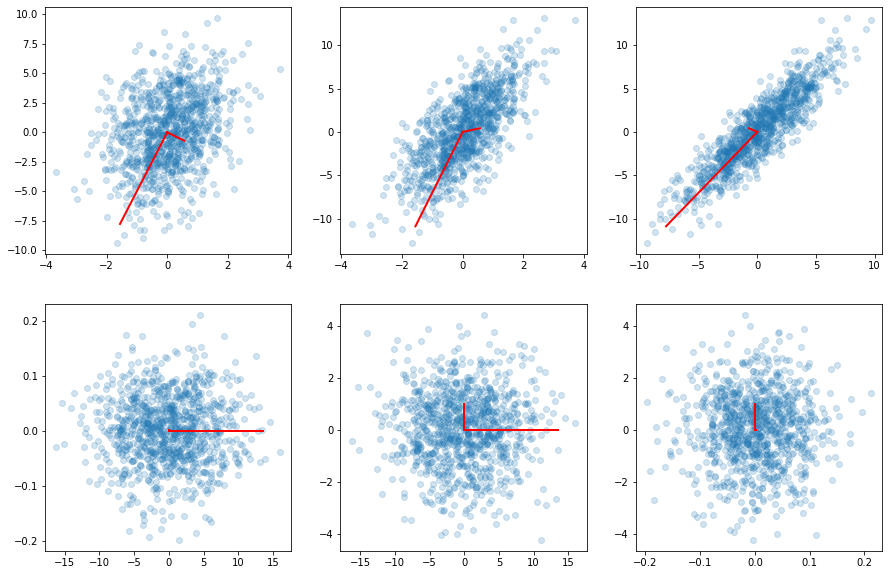

In [76]:
# Plot the new noisy data points
gridsize = (2, 3)
fig = plt.figure(figsize=(15, 10))
ax00 = plt.subplot2grid(gridsize, (0, 0))
ax01 = plt.subplot2grid(gridsize, (0, 1))
ax02 = plt.subplot2grid(gridsize, (0, 2))
ax10 = plt.subplot2grid(gridsize, (1, 0))
ax11 = plt.subplot2grid(gridsize, (1, 1))
ax12 = plt.subplot2grid(gridsize, (1, 2))
scaleFactor=0.5

#original data
l, V = la.eig(np.cov(noisyData))

ax00.scatter(noisyData[0,:], noisyData[1,:], alpha=0.2)
for li, vi in zip(l, V.T):
    ax00.plot([0, scaleFactor*li*vi[0]], [0, scaleFactor*li*vi[1]], 'r-', lw=2)

ax01.scatter(noisyData[0,:], noisyData[2,:], alpha=0.2)
for li, vi in zip(l, V.T):
    ax01.plot([0, scaleFactor*li*vi[0]], [0, scaleFactor*li*vi[2]], 'r-', lw=2)

ax02.scatter(noisyData[1,:], noisyData[2,:], alpha=0.2)
for li, vi in zip(l, V.T):
    ax02.plot([0, scaleFactor*li*vi[1]], [0, scaleFactor*li*vi[2]], 'r-', lw=2)

#new data
l0, V0 = np.linalg.eig(np.dot(noisyData, noisyData.T)/(N-1))

ax10.scatter(Xp[0,:], Xp[1,:], alpha=0.2)
for li, vi in zip(l0, np.diag([1]*3)):
    ax10.plot([0, scaleFactor*li*vi[0]], [0, scaleFactor*li*vi[1]], 'r-', lw=2)

ax11.scatter(Xp[0,:], Xp[2,:], alpha=0.2)
for li, vi in zip(l0, np.diag([1]*3)):
    ax11.plot([0, scaleFactor*li*vi[0]], [0, scaleFactor*li*vi[2]], 'r-', lw=2)
    
ax12.scatter(Xp[1,:], Xp[2,:], alpha=0.2)
for li, vi in zip(l0, np.diag([1]*3)):
    ax12.plot([0, scaleFactor*li*vi[1]], [0, scaleFactor*li*vi[2]], 'r-', lw=2)

#### The addition of noise to the data had very little, if any, impact on the results of the PCA procedure on the new data. The results like almost identical.

3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [ ]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 